In [60]:
using Pkg
# Pkg.update()
Pkg.instantiate()

using DevCommunities
using SimpleHypergraphs
using StatsBase
using Plots, LinearAlgebra
using DelimitedFiles
using Distances


In [ ]:
# g = build_hg("../../hgs/apl.hg")
# num_nodes = nhv(g[1])
# num_edges = nhe(g[1])
# println("Number of nodes: $num_nodes")
# println("Number of edges: $num_edges")

my_tags_so = ["rust" ,"elixir","clojure", "typescript" ,"julia", "python", "delphi", "go" ,"sql", "c#" ,"kotlin", "swift" ,"dart" ,"html", "solidity", "javascript", "f#", "bash" ,"lisp", "apl"]
# order by lexigraphical order
my_tags_so = sort(my_tags_so)

In [10]:
function build_hg_randoms(path)

    nodes = Dict{Int,Int}()
    degree_nodes = Dict{Int,Int}()
    nodes_per_edge = Dict{Int,Vector{Int}}()

    print(nodes)
    hg = Hypergraph(0,0)
    for line in eachline(path)
        # split elemnts of the line by comma
        d = split(line, ",")
        vs = map(x -> parse(Int,(strip(replace(x, r"\[|\]" => "")))), d)
        for v in vs
            if !haskey(nodes, v)
                v_id = SimpleHypergraphs.add_vertex!(hg)
                push!(nodes, v=>v_id)
            end
        end
        # add he 
        vertices = Dict{Int, Bool}(nodes[v] => true for v in vs)

        # count degree of each node
        for v in vs
            if !haskey(degree_nodes, v)
                degree_nodes[v] = 0
            end
            degree_nodes[v] += 1
        end
        
        he_id = SimpleHypergraphs.add_hyperedge!(hg; vertices = vertices)
        push!(nodes_per_edge, he_id => vs)  
    end

    sum_degree_nodes = sum(values(degree_nodes))
    sum_degree_edges = sum(values(length(nodes_per_edge)))

    function prob_nodes(v)
        return degree_nodes[v]/sum_degree_nodes
    end

    function prob_edges(e)
        return length(nodes_per_edge[e])/sum_degree_edges
    end

    random_nodes_probs = Dict{Int,Float64}()
    random_edges_probs = Dict{Int,Float64}()

    for key in keys(nodes)
        pr = prob_nodes(key)
        random_nodes_probs[key] = pr
    end

    for key in keys(nodes_per_edge)
        pr = prob_edges(key)
        random_edges_probs[key] = pr
    end

    random_nodes = Dict{Int,Int}()
    random_nodes_per_edge = Dict{Int,Vector{Int}}()

    random_hg = Hypergraph(0,0)

    rnp = collect(keys(sort(random_nodes_probs)))
    rnp_weights = pweights(ProbabilityWeights(collect(values(sort(random_nodes_probs)))))
    rep = collect(keys(sort(random_edges_probs)))
    rep_weights = pweights(ProbabilityWeights(collect(values(sort(random_edges_probs)))))

    for i in 1:sum_degree_nodes
        v = sample(rnp, rnp_weights)
        e = sample(rep, rep_weights)

        if !haskey(random_nodes, v)
            v_id = SimpleHypergraphs.add_vertex!(random_hg)
            push!(random_nodes, v=>v_id)
        end

        if !haskey(random_nodes_per_edge, e)
            random_nodes_per_edge[e] = []
        end
        random_nodes_per_edge[e] = push!(random_nodes_per_edge[e], v)        
    end

    for key in keys(random_nodes_per_edge)
        vertices = Dict{Int, Bool}(random_nodes[v] => true for v in random_nodes_per_edge[key])
        he_id = SimpleHypergraphs.add_hyperedge!(random_hg; vertices = vertices)
    end

    return random_hg
end

build_hg_randoms (generic function with 1 method)

In [ ]:

rg = build_hg_randoms("../../hgs/apl.hg")
hg_save("../../randoms/randomPIPE", rg)

# open file
r1 = open("../../randoms/randomPIPE")
# substitue in each line "=true" with ","
run(`sed -i '' 's/=true/,/g' ../../randoms/randomPIPE`)
# remove first line
run(`sed -i '' '1d' ../../randoms/randomPIPE`)
# hash and rewriting id
run(`python3 rewrite.py ../../randoms/randomPIPE 1`)

run(`bash orb.sh`)


# println(nhv(random_hg))
# println(nhe(random_hg))
# hg_save("../../randoms/realRandom", random_hg)


In [ ]:
 # open file
 r1 = open("../../randoms/realRandom")
 # substitue in each line "=true" with ","
 run(`sed -i '' 's/=true/,/g' ../../randoms/realRandom`)
 # remove first line
 run(`sed -i '' '1d' ../../randoms/realRandom`)
 # hash and rewriting id
 run(`python3 rewrite.py ../../randoms/realRandom 1`)
 close(r1)

In [11]:
all_arrays = []
for i in 1:20
    # g = build_hg("../../hgs/apl.hg")
    
    println("building hg for tag: "*my_tags_so[i])
    g = build_hg("../../hgs/"*my_tags_so[i]*".hg")

    num_nodes = nhv(g[1])
    num_edges = nhe(g[1])
    println("Number of nodes: $num_nodes")
    println("Number of edges: $num_edges")
    flush(stdout)

    total_random_motif_count = [0 for i in 1:26]
    # generate 5 model and do average counting
    for j in range(1,5)
        rm_pa = build_hg_randoms("../../hgs/"*my_tags_so[i]*".hg")
        hg_save("../../randoms/randomPIPE", rm_pa)
        
        # open file
        r1 = open("../../randoms/randomPIPE")
        # substitue in each line "=true" with ","
        run(`sed -i '' 's/=true/,/g' ../../randoms/randomPIPE`)
        # remove first line
        run(`sed -i '' '1d' ../../randoms/randomPIPE`)
        # hash and rewriting id
        run(`python3 rewrite.py ../../randoms/randomPIPE 1`)
        
        run(`bash orb.sh`)
        
        # run(`bash /Users/ddevin/Documents/MoCHy/run_exact.sh "/Users/ddevin/Documents/vscode/DevCommunities/randoms/randomPIPE.hg"`)
        # run(`bash /Users/ddevin/Documents/MoCHy/run_exact.sh "/Users/ddevin/Documents/vscode/DevCommunities/hgs/apl.hg"`)
        close(r1)
        r2 = open("/Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt")
        array = []
        for line in eachline(r2)
            if occursin("motif", line)
                if occursin("counting", line)
                    continue
                end
                # find integers in line after ":"
                motif = parse.(Int64, split(line, ":")[2:end])
                push!(array, motif[1])
            end
        end
        # array of any to array of integers
        array = convert(Array{Int64}, array)
        total_random_motif_count = [x + y for (x, y) in zip(array, total_random_motif_count)]
        close(r2)
        println("done with random model "*string(j))
        flush(stdout)
        # flush
    end

    total_random_motif_count = [x / 5 for x in total_random_motif_count]
    total_random_motif_count = ceil.(Int64, total_random_motif_count)
    println(total_random_motif_count)
    push!(all_arrays, total_random_motif_count)
end

println(all_arrays)
# write to file
open("/Users/ddevin/Documents/vscode/DevCommunities/results/all_motifs_counted.csv", "w") do io
    for i in 1:20
        # write(io, string(my_tags_so[i]))
        # write(io, ",")
        for j in 1:26
            if length(all_arrays[i]) == 0
                write(io, string(0))
                write(io, ",")
            else
                write(io, string(all_arrays[i][j]))
                write(io, ",")
            end
        end
        write(io, "\n")
    end
end





building hg for tag: apl
Number of nodes: 1341
Number of edges: 1136


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[153671, 272179, 947, 2808, 5329, 16939, 0, 8, 5, 86, 25, 261, 0, 0, 1, 2, 0, 0, 3252, 16199, 15320, 92331, 0, 18, 165, 419]
building hg for tag: bash
Number of nodes: 18484
Number of edges: 17540


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[31844146, 85084623, 68422, 339600, 702140, 3763084, 17, 341, 732, 8925, 4094, 63253, 0, 9, 53, 313, 0, 0, 1443003, 13133531, 9859064, 109687666, 0, 4975, 91150, 503942]
building hg for tag: c#
Number of nodes: 81360


Number of edges: 102199


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[651463655, 1498253742, 229633, 938897, 1702107, 7162751, 102, 151, 302, 3185, 752, 15874, 0, 0, 0, 0, 0, 0, 6769743, 48311079, 41094540, 333941166, 0, 2053, 38748, 168703]
building hg for tag: clojure
Number of nodes: 694
Number of edges: 915


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}(

)

done with random model 5


[141302, 318769, 2019, 7231, 15534, 57981, 3, 72, 86, 829, 401, 3451, 0, 3, 20, 75, 0, 0, 10445, 64685, 49858, 414869, 0, 148, 1883, 7138]
building hg for tag: dart
Number of nodes: 23448


Number of edges: 32499


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[98816921, 274164044, 61129, 345523, 529654, 3001592, 0, 71, 333, 1637, 857, 12918, 0, 0, 0, 12, 0, 0, 893564, 8203451, 6678661, 68506737, 0, 741, 12165, 68120]
building hg for tag: delphi
Number of nodes: 1803
Number of edges: 2673


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[3814027, 5055938, 41855, 84532, 206902, 421658, 67, 316, 683, 3138, 1372, 8549, 0, 3, 23, 53, 0, 0, 130533, 581307, 516042, 2467106, 0, 752, 6430, 14821]
building hg for tag: elixir
Number of nodes: 810
Number of edges: 972


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[402116, 524979, 4442, 14524, 21637, 68101, 10, 55, 124, 794, 366, 2572, 0, 2, 9, 31, 0, 0, 10967, 65231, 44446, 300299, 0, 115, 1269, 3512]
building hg for tag: f#
Number of nodes: 822
Number of edges: 1347


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[1092956, 1585705, 19869, 52481, 96711, 247805, 40, 288, 489, 3760, 1468, 10344, 1, 5, 71, 123, 0, 0, 50617, 250352, 195685, 1112194, 0, 602, 5514, 13892]
building hg for tag: go
Number of nodes: 78704


Number of edges: 76050


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[536819329, 1270170935, 205515, 661463, 1459227, 4942654, 0, 131, 33, 1573, 568, 4954, 0, 0, 0, 0, 0, 0, 2166885, 17640048, 13933536, 122467499, 0, 292, 11110, 47280]
building hg for tag: html
Number of nodes: 122961


Number of edges: 113988


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[206853338, 581252202, 29710, 188467, 280389, 1709110, 0, 91, 0, 634, 0, 1724, 0, 0, 0, 0, 0, 0, 1385416, 14969753, 10903737, 127803204, 0, 211, 5382, 31136]
building hg for tag: javascript
Number of nodes: 227390


Number of edges: 279061


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[2806654584, 7478612687, 473860, 2107476, 3992954, 18924320, 0, 176, 178, 3764, 1437, 18070, 0, 0, 0, 0, 0, 0, 23119784, 212251901, 167446477, 1743211963, 0, 5172, 88230, 472182]
building hg for tag: julia
Number of nodes: 1945
Number of edges: 3214


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[8895788, 15432729, 120847, 337908, 664411, 1866812, 190, 1447, 2621, 18629, 8545, 58526, 4, 30, 240, 620, 0, 0, 252287, 1499227, 1181897, 7893934, 0, 1862, 22517, 68873]
building hg for tag: kotlin
Number of nodes: 22706


Number of edges: 26508


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[96186546, 217988152, 77217, 333400, 572703, 2535070, 11, 150, 234, 1942, 761, 11686, 0, 0, 0, 0, 0, 0, 859220, 6340776, 5436627, 44037961, 0, 898, 12767, 54328]
building hg for tag: lisp
Number of nodes: 665
Number of edges: 933


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[89141, 229537, 2147, 6992, 18686, 64066, 10, 72, 165, 1265, 636, 5142, 1, 5, 44, 123, 0, 0, 16991, 103507, 85123, 669728, 0, 338, 4219, 15170]
building hg for tag: python
Number of nodes: 295974


Number of edges: 431319


Dict{Int64, Int64}()

done with random model 1


run_approx_ver2_par.sh: line 2:  1247 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt


Dict{Int64, Int64}()

done with random model 2


run_approx_ver2_par.sh: line 2:  1260 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

run_approx_ver2_par.sh: line 2:  1273 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt


done with random model 4


run_approx_ver2_par.sh: line 2:  1286 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt


Dict{Int64, Int64}()

done with random model 5


Int64[]
building hg for tag: rust


run_approx_ver2_par.sh: line 2:  1299 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt


Number of nodes: 7957
Number of edges: 10984


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[19980875, 35381737, 62625, 209914, 386655, 1340781, 41, 308, 464, 4750, 1463, 16818, 0, 4, 40, 64, 0, 0, 657775, 4277904, 3228620, 23790954, 0, 1931, 24796, 85715]
building hg for tag: solidity
Number of nodes: 3403
Number of edges: 3103


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[17052781, 31680599, 58391, 194756, 320489, 1015974, 20, 208, 320, 2989, 1284, 8960, 0, 0, 7, 15, 0, 0, 47402, 306371, 256216, 1637306, 0, 104, 1297, 3456]
building hg for tag: sql
Number of nodes: 139097


Number of edges: 154341


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

run_approx_ver2_par.sh: line 2:  1433 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt


done with random model 2


Dict{Int64, Int64}()

run_approx_ver2_par.sh: line 2:  1445 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt


done with random model 3


Dict{Int64, Int64}()

run_approx_ver2_par.sh: line 2:  1457 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt


done with random model 4


Dict{Int64, Int64}()

run_approx_ver2_par.sh: line 2:  1469 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt


done with random model 5


Int64[]
building hg for tag: swift


run_approx_ver2_par.sh: line 2:  1482 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt


Number of nodes: 23712
Number of edges: 38870


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[456424202, 920216125, 723792, 2924147, 4784969, 19976993, 126, 2233, 3663, 41716, 17977, 171107, 0, 0, 250, 428, 0, 0, 7928423, 54444597, 44166311, 334484244, 0, 12324, 190449, 675260]
building hg for tag: typescript
Number of nodes: 51998


Number of edges: 54126


Dict{Int64, Int64}()

done with random model 1


Dict{Int64, Int64}()

done with random model 2


Dict{Int64, Int64}()

done with random model 3


Dict{Int64, Int64}()

done with random model 4


Dict{Int64, Int64}()

done with random model 5


[255554133, 601623192, 119860, 450270, 901371, 3451510, 0, 82, 124, 1259, 240, 6568, 0, 0, 0, 0, 0, 0, 1239711, 10487437, 8290747, 75201800, 0, 421, 7657, 38600]
Any

[[153671, 272179, 947, 2808, 5329, 16939, 0, 8, 5, 86, 25, 261, 0, 0, 1, 2, 0, 0, 3252, 16199, 15320, 92331, 0, 18, 165, 419], [31844146, 85084623, 68422, 339600, 702140, 3763084, 17, 341, 732, 8925, 4094, 63253, 0, 9, 53, 313, 0, 0, 1443003, 13133531, 9859064, 109687666, 0, 4975, 91150, 503942], [651463655, 1498253742, 229633, 938897, 1702107, 7162751, 102, 151, 302, 3185, 752, 15874, 0, 0, 0, 0, 0, 0, 6769743, 48311079, 41094540, 333941166, 0, 2053, 38748, 168703], [141302, 318769, 2019, 7231, 15534, 57981, 3, 72, 86, 829, 401, 3451, 0, 3, 20, 75, 0, 0, 10445, 64685, 49858, 414869, 0, 148, 1883, 7138], [98816921, 274164044, 61129, 345523, 529654, 3001592, 0, 71, 333, 1637, 857, 12918, 0, 0, 0, 12, 0, 0, 893564, 8203451, 6678661, 68506737, 0, 741, 12165, 68120], [3814027, 5055938, 41855, 84532, 206902, 421658, 67, 316, 683, 3138, 1372, 8549, 0, 3, 23, 53, 0, 0, 130533, 581307, 516042, 2467106, 0, 752, 6430, 14821], [402116, 524979, 4442, 14524, 21637, 68101, 10, 55, 124, 794, 366, 257

BoundsError: BoundsError: attempt to access 0-element Vector{Int64} at index [1]

In [20]:
############## SINGLE RUN ##################

g = build_hg("../../hgs/"*"sql"*".hg")

num_nodes = nhv(g[1])
num_edges = nhe(g[1])
println("Number of nodes: $num_nodes")
println("Number of edges: $num_edges")
flush(stdout)

total_random_motif_count = [0 for i in 1:26]
# generate 5 model and do average counting
for j in range(1,5)
    rm_pa = build_hg_randoms("../../hgs/"*"sql"*".hg")
    hg_save("../../randoms/randomPIPE", rm_pa)
    
    # open file
    r1 = open("../../randoms/randomPIPE")
    # substitue in each line "=true" with ","
    run(`sed -i '' 's/=true/,/g' ../../randoms/randomPIPE`)
    # remove first line
    run(`sed -i '' '1d' ../../randoms/randomPIPE`)
    # hash and rewriting id
    run(`python3 rewrite.py ../../randoms/randomPIPE 1`)
    
    run(`bash orb.sh`)
    
    # run(`bash /Users/ddevin/Documents/MoCHy/run_exact.sh "/Users/ddevin/Documents/vscode/DevCommunities/randoms/randomPIPE.hg"`)
    # run(`bash /Users/ddevin/Documents/MoCHy/run_exact.sh "/Users/ddevin/Documents/vscode/DevCommunities/hgs/apl.hg"`)
    close(r1)
    r2 = open("/Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt")
    array = []
    for line in eachline(r2)
        if occursin("motif", line)
            if occursin("counting", line)
                continue
            end
            # find integers in line after ":"
            motif = parse.(Int64, split(line, ":")[2:end])
            push!(array, motif[1])
        end
    end
    # array of any to array of integers
    array = convert(Array{Int64}, array)
    total_random_motif_count = [x + y for (x, y) in zip(array, total_random_motif_count)]
    close(r2)
    println("done with random model "*string(j))
    println(total_random_motif_count)
    flush(stdout)
    # flush
end

total_random_motif_count = [x / 5 for x in total_random_motif_count]
total_random_motif_count = ceil.(Int64, total_random_motif_count)
println(total_random_motif_count)
# push!(all_arrays, total_random_motif_count)

Number of nodes: 139097
Number of edges: 154341


Dict{Int64, Int64}()

run_approx_ver2_par.sh: line 2:  1755 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt


done with random model 1
Int64[]


Dict{Int64, Int64}()

done with random model 2
Int64[]


Dict{Int64, Int64}()

run_approx_ver2_par.sh: line 2:  1767 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt


done with random model 3
Int64[]


Dict{Int64, Int64}()

run_approx_ver2_par.sh: line 2:  1779 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt


done with random model 4
Int64[]


Dict{Int64, Int64}()

done with random model 5
Int64[]


Int64[]


run_approx_ver2_par.sh: line 2:  1791 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt
run_approx_ver2_par.sh: line 2:  1803 Killed                  ./approx_ver2_par 10000 4 $1 > /Users/ddevin/Documents/vscode/DevCommunities/script_dump/dumpPIPE.txt


In [21]:
# num_motifs = [1077,818707,23,7,5702,6152,25,1,131,27,10,4,0,0,0,0,5,1,8390,1397,41097,124693,9,582,145,53]
# num_motifs = [2070, 11469, 44796591, 58275821, 16910646, 34130003, 16, 93583226, 404737, 293960662, 70840, 175279493, 1, 4172338, 55998189, 362027234, 0, 0, 31323, 12423927, 14751, 27466910, 0, 152556, 716568, 7659269]

function cps(motifs, motifs_random)
    eps = 1 #fixed in the paper
    deltas = []
    sum_deltas = 0
    for i in 1:length(motifs)
        t = (motifs[i]-motifs_random[i])/(motifs[i]+motifs_random[i]+eps)
        push!(deltas, t)
        sum_deltas += t^2
    end
    cp = []
    for i in 1:length(motifs)
        push!(cp, deltas[i]/sqrt(sum_deltas))
    end
    return cp
end

# cp = cps(num_motifs, motifs_random)
# println(cp)

cps (generic function with 1 method)

In [ ]:
using CSV, DataFrames
data = CSV.read("../../hgs/motifs.csv", DataFrame, header=false)
# for each column create an array of the values
w = open("../../results/cpprofilesAPL.csv", "w")

for i in 1:size(data, 2)
    col = data[:, i]
    col = convert(Array{Int64, 1}, col)
    cp = cps(col, num_motifs)
    new_line = join(cp, ",")
    
    write(w, new_line * "\n")
end
close(w)



In [32]:
using CSV, DataFrames
data = CSV.read("../../hgs/motifs.csv", DataFrame, header=false)
dataRandom = CSV.read("../../results/all_motifs_counted.csv", DataFrame, header=false)
# for each column create an array of the values
w = open("../../results/cpprofilesALL.csv", "w")
# println(data)
# println(dataRandom)
# match column of data with column of dataRandom
for i in 1:size(data, 2)
    col = data[:, i]
    col = convert(Array{Int64, 1}, col)
    random_motif = dataRandom[i, :]
    # println(col)
    # println(random_motif)
    cp = cps(col, random_motif)
    new_line = join(cp, ",")
    write(w, new_line * "\n")
end

# for i in 1:size(data, 2)
#     col = data[:, i]
#     col = convert(Array{Int64, 1}, col)
#     random_motif = dataRandom[:, i]
#     cp = cps(col, num_motifs)
#     new_line = join(cp, ",")
    
#     # write(w, new_line * "\n")
# end
close(w)



[0.0 0.9334342063567687 0.44710588058825096 0.6058071068841856 0.33000130044926856 0.2203861789944035 0.3559049296794603 0.2018172432656694 0.5749740939662129 0.5038722910664937 0.6848609814742708 0.2457367474174491 0.36269943629621615 0.4799671884553368 0.7451720193230509 0.21286766386101574 0.29186007134298386 0.6669466943403841 0.1323494537398464 0.18264665825914228; 0.9334342063567687 0.0 0.33126155266482604 0.5251565684402479 0.8539197668130314 0.6829497727627336 0.8130717003935379 0.8448547346499928 0.6518957491669307 0.4435628515764195 0.5192610299758182 0.6104661655846608 0.5339324951920628 0.9453202171431161 0.4989792823088989 0.5679173320805648 0.6387053235749541 0.2885885401272722 0.7526050736238525 0.6295383370068188; 0.44710588058825096 0.33126155266482604 0.0 0.3334773883227403 0.3969864896899762 0.3410302068726776 0.4106867868406695 0.3559589482350677 0.36612118862097887 0.21505410129640046 0.3454410156823957 0.30451224162233137 0.19077553779101608 0.5050027317277646 0.3

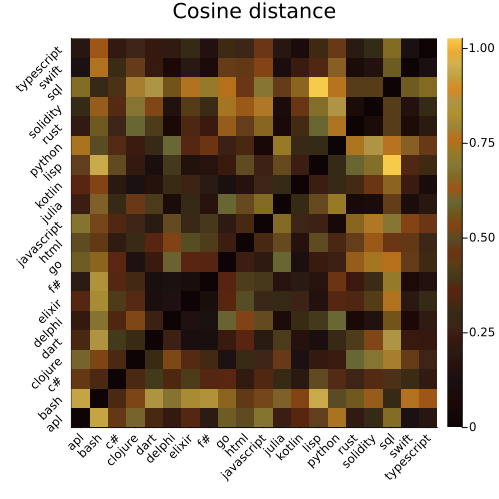

In [82]:
# read matrix from csv file
m = readdlm("../../results/cpprofilesALL.csv", ',', Float64)
mm = pairwise(CosineDist(), m')
println(mm)
# create mmmatrix that use Cosine similarity
#:viridis
h = heatmap(mm, color=:leonardo, title="Cosine distance", xticks=([i for i in 1:20], my_tags_so), yticks=([i for i in 1:20], my_tags_so), xrotation=45, yrotation=45, size=(500,500))

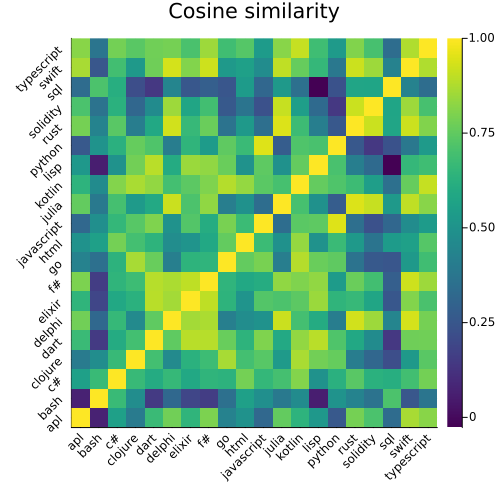

In [87]:
# using LinearAlgebra
# read matrix from csv file
m = readdlm("../../results/cpprofilesALL.csv", ',', Float64)
# matrix 20x20 of Float64
mm = []


########## COS similarity ##########
for row1 in eachrow(m)
    # mm_row = []
    for row2 in eachrow(m)
        dot = row1'row2
        normalization1 = norm(row1)
        normalization2 = norm(row2)
        cos_sim = dot/(normalization1*normalization2)
        push!(mm, cos_sim)
    end
    # push!(mm, mm_row)
end
# convert mm to a format readable for Plots heatmap
mm = reshape(mm, 20, 20)
######################################

h = heatmap(mm, color=:viridis, title="Cosine similarity", xticks=([i for i in 1:20], my_tags_so), yticks=([i for i in 1:20], my_tags_so), xrotation=45, yrotation=45, size=(500,500))

In [ ]:
for i in 1:20
    # g = build_hg("../../hgs/apl.hg")
    
    println("building hg for tag: "*my_tags_so[i])
    g = build_hg("../../hgs/"*my_tags_so[i]*".hg")

    num_nodes = nhv(g[1])
    num_edges = nhe(g[1])
    println("Number of nodes: $num_nodes")
    println("Number of edges: $num_edges")
    flush(stdout)

    ccs = SimpleHypergraphs.get_connected_components(g[1])
    ccs = sort(ccs, by=length, rev=true)
    # distribution of component sizes
    ccs_len = length.(ccs)


In [ ]:
using PyPlot

for i in 1:20
    # g = build_hg("../../hgs/apl.hg")
    
    println("building hg for tag: "*my_tags_so[i])
    g = build_hg("../../hgs/"*my_tags_so[i]*".hg")

    dict_degree = DevCommunities.degree_histogram(g[1], normalized=true)
    # bar plot of the degree distribution
    fig,axs = subplots()
    axs.bar(collect(keys(dict_degree)), collect(values(dict_degree)), color="red")
    gcf()

